In [60]:
import os
import time
import random
from PIL import Image
from skimage import io
from skimage.transform import resize
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from pathlib import Path
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
%matplotlib inline

MAE = tf.keras.losses.MeanAbsoluteError()
MSE = tf.keras.losses.MeanSquaredError()

In [2]:
SAVED_MODEL_PATH = "https://tfhub.dev/captain-pool/esrgan-tf2/1"
model = hub.load(SAVED_MODEL_PATH)

In [91]:
min_temps = {}
max_temps = {}

def png(image, in_path, out_path):
    band = np.load(in_path + image)
    min_temps[image[:-5]] = band.min()
    max_temps[image[:-5]] = band.max()
    band = band - band.min()
    band = (band/band.max())*255
    GSband = np.zeros((band.shape[0], band.shape[1], 3))
    GSband[:,:,0]= band
    GSband[:,:,1]= band
    GSband[:,:,2]= band
    GSband = GSband.astype('uint8')
    png = Image.fromarray(GSband)
    image = image[:-4]
    png.save(out_path + image + ".png")

def random_pngs():
    path = '../../GOES_Files/diff_files/'
    for x in range(20):
        file = random.choice(os.listdir(path))
        png(file, path, '../../GOES_Files/png_files/')

In [92]:
# random_pngs()

In [107]:
def preprocess_image(image_path):
    #need to divide values
    hr_image = tf.image.decode_image(tf.io.read_file(image_path))
    if hr_image.shape[-1] == 4:
        hr_image = hr_image[...,:-1]
    hr_size = (tf.convert_to_tensor(hr_image.shape[:-1]) // 2) * 2
    hr_image = tf.image.crop_to_bounding_box(hr_image, 0, 0, hr_size[0], hr_size[1])
    hr_image = tf.cast(hr_image, tf.float32)
    return tf.expand_dims(hr_image, 0)

def downscale_image(image):
    image_size = []
    if len(image.shape) == 3:
        image_size = [image.shape[1], image.shape[0]]
    else:
        raise ValueError("Dimension mismatch. Can work only on single image.")

    image = tf.squeeze(tf.cast(tf.clip_by_value(image, 0, 255), tf.uint8))

    lr_image = np.asarray(
#     Image.fromarray(image.numpy()).resize([image_size[0] // 4, image_size[1] // 4], Image.BICUBIC))
    Image.fromarray(image.numpy()).resize([image_size[0] // 2, image_size[1] // 2], Image.NEAREST))

    lr_image = tf.expand_dims(lr_image, 0)
    lr_image = tf.cast(lr_image, tf.float32)
    return lr_image


def m_learning(fileID):
    band = fileID[-58:-56]
    hr_image = preprocess_image(fileID)
    hr_image = tf.squeeze(hr_image)
    lr_image = downscale_image(hr_image)
    fake_image = model(lr_image)
    fake_image = tf.squeeze(fake_image)
    fake_image = resize(fake_image, (500, 500, 3))
    lr_image = resize(tf.squeeze(lr_image), (500, 500, 3))

#     controlmae = np.sum(resize(tf.squeeze(lr_image), (500, 500, 3)) - hr_image)/(500*500)
#     controlrmse = np.sqrt(np.sum((resize(tf.squeeze(lr_image), (500, 500, 3)) - hr_image)**2)/(500*500))
#     mae = np.sum(fake_image - hr_image)/(500*500)
#     rmse = np.sqrt(np.sum(fake_image - hr_image)**2)/(500*500)
    
    controlmae = MAE(hr_image, lr_image).numpy()
    controlrmse = np.sqrt(MSE(hr_image, lr_image).numpy())
    mae = MAE(hr_image, fake_image).numpy()
    rmse = np.sqrt(MSE(hr_image, fake_image).numpy())
    
    controlmae = controlmae/255*max_temps[fileID[27:-5]] + min_temps[fileID[27:-5]]
    controlrmse = controlrmse/255*max_temps[fileID[27:-5]] + min_temps[fileID[27:-5]]
    mae = mae/255*max_temps[fileID[27:-5]] + min_temps[fileID[27:-5]]
    rmse = rmse/255*max_temps[fileID[27:-5]] + min_temps[fileID[27:-5]]
    
    table.append({'File': fileID, 'Control MAE': controlmae, 'Control RMSE': controlrmse, 'MAE': mae, 'RMSE': rmse})

In [108]:
table = []
path = '../../GOES_Files/png_files/'
for file in os.listdir(path):
    try:
        m_learning(path + file)
    except:
        print(file)

.ipynb_checkpoints


In [109]:
x = pd.DataFrame(table)
agg_function = {'Control MAE': 'mean', 'Control RMSE': 'mean', 'MAE': 'mean', 'RMSE': 'mean'}
y = x.agg(agg_function)
y

Control MAE    -3.157883
Control RMSE   -2.812803
MAE            -2.896036
RMSE           -2.435142
dtype: float64

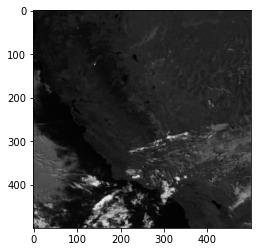

In [111]:
path = '../../GOES_Files/png_files/'
image = Image.open(path + random.choice(os.listdir(path)))
image = np.asarray(image)
plt.imshow(image)

In [103]:
max_temps

{'OR_ABI-L1b-RadC-M3Cdiff_G17_s20183210537147_e20183210539531_c2018321053955': 31.538239,
 'OR_ABI-L1b-RadC-M3Cdiff_G17_s20183291107190_e20183291109574_c2018329111000': 19.440552,
 'OR_ABI-L1b-RadC-M3Cdiff_G17_s20183281837189_e20183281839573_c2018328184000': 44.85559,
 'OR_ABI-L1b-RadC-M3Cdiff_G17_s20183281922189_e20183281924573_c2018328192500': 47.742767,
 'OR_ABI-L1b-RadC-M3Cdiff_G17_s20183230437189_e20183230439574_c2018323044000': 22.739609,
 'OR_ABI-L1b-RadC-M3Cdiff_G17_s20183260142190_e20183260144514_c2018326014454': 23.846222,
 'OR_ABI-L1b-RadC-M3Cdiff_G17_s20183202202147_e20183202204531_c2018320220455': 49.319305,
 'OR_ABI-L1b-RadC-M3Cdiff_G17_s20183280717190_e20183280719574_c2018328072000': 22.307068,
 'OR_ABI-L1b-RadC-M3Cdiff_G17_s20183171912219_e20183171914543_c2018317191457': 49.008453,
 'OR_ABI-L1b-RadC-M3Cdiff_G17_s20183171157219_e20183171159543_c2018317115957': 59.064606,
 'OR_ABI-L1b-RadC-M3Cdiff_G17_s20183241342189_e20183241344515_c2018324134455': nan,
 'OR_ABI-L1b-RadC